In [1]:
#Initiating Packages
import ROOT as r
import numpy as np
import math

Welcome to JupyROOT 6.22/00


In [2]:
#Opening the simulation ROOT file
fsimu = r.TFile("samples/Run2012BC_DoubleMuParked_skim_v2.root")
#listing the content of the file
fsimu.ls()
t = fsimu.Get("Events")

TFile**		samples/Run2012BC_DoubleMuParked_skim_v2.root	
 TFile*		samples/Run2012BC_DoubleMuParked_skim_v2.root	
  KEY: TTree	Events;1	Events


In [3]:
#See how many events are there in this tree
nEntries = t.GetEntries()
print(nEntries)

529


In [4]:
#test a examplar event
t.Show(76)

======> EVENT:76
 run             = 196218
 luminosityBlock = 166
 event           = 227768389
 HLT_IsoMu24_eta2p1 = 1
 HLT_IsoMu24     = 1
 HLT_IsoMu17_eta2p1_LooseIsoPFTau20 = 1
 PV_npvs         = 27
 PV_x            = 0.070507
 PV_y            = 0.0639399
 PV_z            = -8.00438
 nMuon           = 4
 Muon_pt         = 36.533, 
                  10.4773, 27.2219, 14.5257
 Muon_eta        = 2.37073, 
                  2.18417, 2.00538, 2.04798
 Muon_phi        = -1.0735, 
                  0.852362, 2.05706, 2.43646
 Muon_mass       = 0.105658, 
                  0.105658, 0.105658, 0.105658
 Muon_charge     = 1, 
                  1, -1, -1
 Muon_pfRelIso03_all = 0.0292253, 
                  0.343248, 0.135483, 0
 Muon_pfRelIso04_all = 0.0519239, 
                  0.343248, 0.135483, 0.113349
 Muon_tightId    = 1, 
                  1, 1, 1
 Muon_softId     = 1, 
                  1, 1, 1
 Muon_dxy        = 0.00323057, 
                  0.00221343, -0.000608462, -0.00025283
 M

In [5]:
c = r.TCanvas('c1','c1',800,600)

In [6]:
#Creating a histogram for 2e2u invmass
h_invmass2e2u = r.TH1F('invmass2e2u','invmass2e2u',55,70,180)
h_invmass2e2u.SetFillColor(0)
h_invmass2e2u.SetLineColor(r.kBlue)
h_invmass2e2u.Draw()
c.Update()

In [7]:
def compare(Zmass1,Zmass2):
    d1 = abs(90-Zmass1)
    d2 = abs(90-Zmass2)
    if d1>d2: return True
    return False

In [8]:
## write a function that computes the invariant mass given the event
## the list version
def invmass(Leptons):
    m = 0
    px = 0
    py = 0
    pz = 0
    e = 0
    for lep in Leptons:
        px += lep['pt']*math.cos(lep['phi'])
        py += lep['pt']*math.sin(lep['phi'])
        theta = 2.*math.atan(np.exp(-lep['eta'])) 
        pz += lep['pt']/math.tan(theta)
        e += np.sqrt(lep['pt']**2 + (lep['pt']/np.tan(theta))**2 + lep['mass']**2)
    
    m = np.sqrt(e**2 - px**2 - py**2 - pz**2)    
    ## OR in the massless muon limit, the formula can be more compact:
    #m  = np.sqrt(2*pt[0]*pt[1]*(np.cosh(eta[0]-eta[1])-np.cos(phi[0]-phi[1])))
    return m

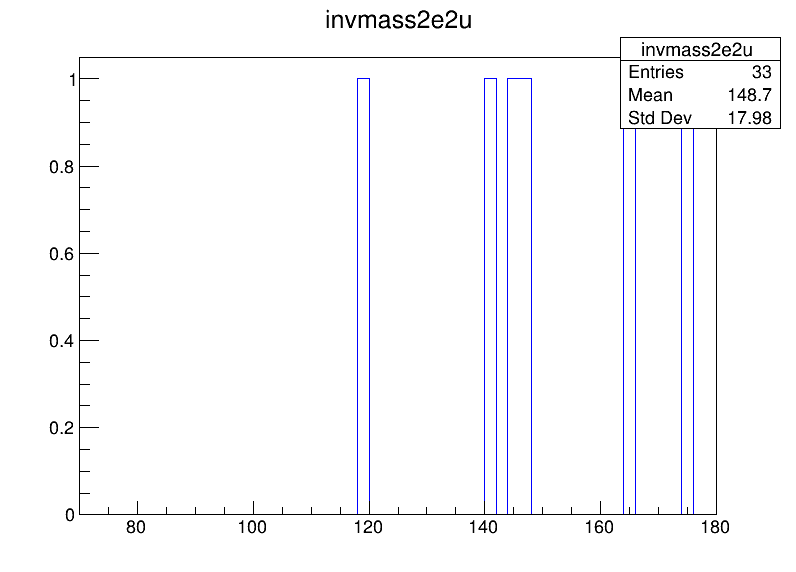

In [9]:
#selecting the 2e2u events
for i in range(0,nEntries):
    t.GetEntry(i)
    nGoodElectron = 0
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if abs(Erellso) >= 0.4: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy**2+Edz**2)/(t.Electron_dxyErr[j]**2+t.Electron_dzErr[j]**2))
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)       
    if nGoodElectron != 2: continue
    #2 electrons have the opposite charge    
    if totCharge != 0: continue    
    Zmass1 = invmass(Leptons)
    Lpt1 = max(Leptons[0]['pt'],Leptons[1]['pt'])
    Lpt2 = min(Leptons[0]['pt'],Leptons[1]['pt'])
    if (Lpt1<=20)or(Lpt2<=10): continue        
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if abs(Mrellso) >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy**2+Mdz**2)/(t.Muon_dxyErr[j]**2+t.Muon_dzErr[j]**2))
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)    
    if nGoodElectron + nGoodMuon != 4: continue 
    #2 muons have the opposite charge     
    if totCharge != 0: continue  
    Lpt1 = max(Leptons[2]['pt'],Leptons[3]['pt'])
    Lpt2 = min(Leptons[2]['pt'],Leptons[3]['pt'])    
    Zmass2 = invmass(Leptons[2:])  
    if (compare(Zmass1,Zmass2)):
        x = Zmass1
        Zmass1 = Zmass2
        Zmass2 = x
    if (Lpt1<=20)or(Lpt2<=10): continue    
    if (Zmass1<40)or(Zmass1>120): continue
    if (Zmass2<12)or(Zmass2>120): continue    
    h_invmass2e2u.Fill(invmass(Leptons))
c.Update()
c.Draw()

In [10]:
outf = r.TFile.Open('data_histograms.root','RECREATE')
outf.cd()
h_invmass2e2u.Write()

675

In [11]:
#Creating a histogram for 4u invmass
h_invmass4u = r.TH1F('invmass4u','invmass4u',55,70,180)
h_invmass4u.SetFillColor(0)
h_invmass4u.SetLineColor(r.kRed)
h_invmass4u.Draw()
c.Update()

In [12]:
def check(Leptons):
    Pair = list()
    AntiPair = list()
    Pair.append(Leptons[0])
    AntiPair.append(Leptons[1])
    for j in range(2,4):
        Pair.append(Leptons[j])
        AntiPair.append(Leptons[5-j])
        Zmass1 = invmass(Pair)
        Zmass2 = invmass(AntiPair)
        Lpt1 = max(Leptons[0]['pt'],Leptons[j]['pt'])
        Lpt2 = min(Leptons[0]['pt'],Leptons[j]['pt'])
        Lpt3 = max(Leptons[1]['pt'],Leptons[5-j]['pt'])
        Lpt4 = min(Leptons[1]['pt'],Leptons[5-j]['pt'])
        if (compare(Zmass1,Zmass2)):
            x = Zmass1
            Zmass1 = Zmass2
            Zmass2 = x
        if (Lpt1>20)and(Lpt2>10)and(Lpt3>20)and(Lpt4>10)and(Zmass1>=40)and(Zmass1<=120)and(Zmass2>=12)and(Zmass2<=120): 
            return True
        Pair.remove(Leptons[j])
        AntiPair.remove(Leptons[5-j])
    return False  

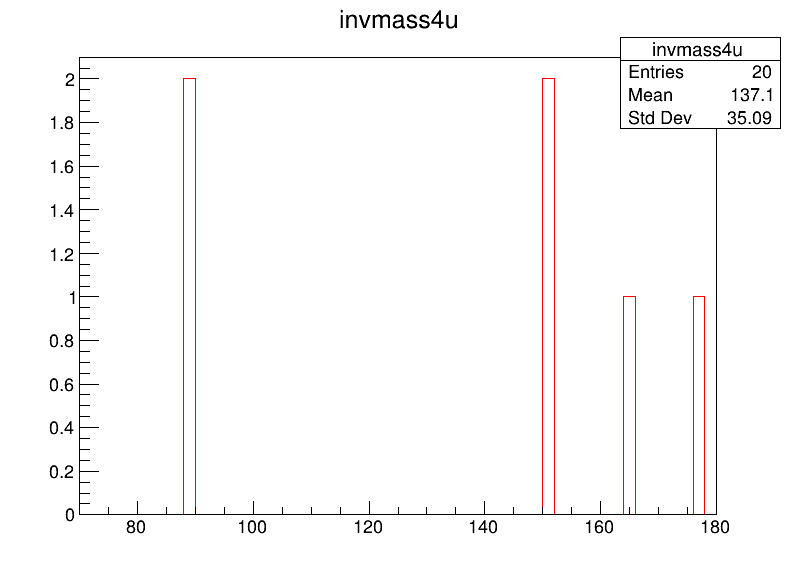

In [13]:
#selecting the 4u events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if abs(Mrellso) >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy**2+Mdz**2)/(t.Muon_dxyErr[j]**2+t.Muon_dzErr[j]**2))
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)
    if nGoodMuon != 4: continue 
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_invmass4u.Fill(invmass(Leptons))  
c.Update()
c.Draw()

In [14]:
outf.cd()
h_invmass4u.Write()

667

In [15]:
#Opening the simulation ROOT file
fsimu = r.TFile("samples/Run2012BC_DoubleElectron_skim_v2.root")
#listing the content of the file
fsimu.ls()
t = fsimu.Get("Events")

TFile**		samples/Run2012BC_DoubleElectron_skim_v2.root	
 TFile*		samples/Run2012BC_DoubleElectron_skim_v2.root	
  KEY: TTree	Events;1	Events


In [16]:
#See how many events are there in this tree
nEntries = t.GetEntries()
print(nEntries)

703


In [17]:
#Creating a histogram for 4e invmass
h_invmass4eB = r.TH1F('invmass4eB','invmass4eB',55,70,180)
h_invmass4eB.Draw()
h_invmass4eB.SetFillColor(0)
h_invmass4eB.SetLineColor(r.kGreen)
c.Update()

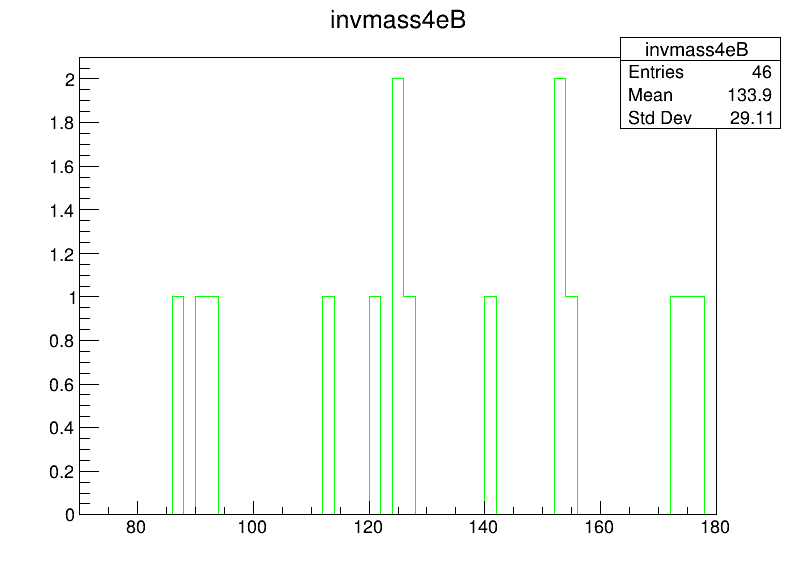

In [18]:
#selecting the 4e events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    nGoodElectron = 0
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if abs(Erellso) >= 0.4: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy**2+Edz**2)/(t.Electron_dxyErr[j]**2+t.Electron_dzErr[j]**2))
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)   
    if nGoodElectron != 4: continue
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_invmass4eB.Fill(invmass(Leptons))  
c.Update()
c.Draw()

In [19]:
outf.cd()
h_invmass4eB.Write()

682

In [20]:
outf.Close()

In [21]:
inf = r.TFile("data_histograms.root")
inf.ls()

TFile**		data_histograms.root	
 TFile*		data_histograms.root	
  KEY: TH1F	invmass2e2u;1	invmass2e2u
  KEY: TH1F	invmass4u;1	invmass4u
  KEY: TH1F	invmass4eB;1	invmass4eB


In [22]:
DataTHS = r.THStack()

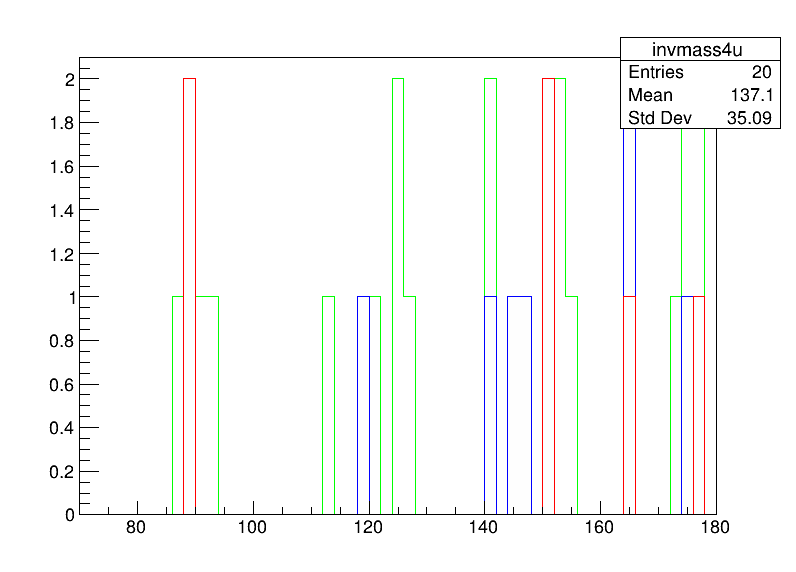

In [23]:
DataTHS.Add(inf.Get('invmass4u'))
DataTHS.Add(inf.Get('invmass2e2u'))
DataTHS.Add(inf.Get('invmass4eB'))
DataTHS.Draw()
c.Update()
c.Draw()